**Importing the Dependencies**

In [ ]:
import sys
!{sys.executable} -m pip install hyperopt
!{sys.executable} -m pip install nltk
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install wordcloud
!{sys.executable} -m pip install pickle

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
import warnings
warnings.filterwarnings('ignore')
from tabulate import tabulate
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [7]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


**Load the dataset**

In [8]:
data = pd.read_csv('fake_news.csv')
actual_data = pd.read_csv('fake_news.csv'')

# Preprocessing

**Remove NULL values**

In [9]:
data.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [10]:
data.dropna(inplace=True)

In [11]:
data.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

**Remove unwanted columns**

In [12]:
data.drop(columns=['id'], inplace=True)

In [13]:
data.isnull().sum()

title     0
author    0
text      0
label     0
dtype: int64


# Exploratory Data Analysis


In [14]:
from tabulate import tabulate

alldata = ['All', data['title'].apply(len).mean(), data['title'].apply(len).min(), data['title'].apply(len).max()]
realdata = ['Real', data['title'][data['label'] == 0].apply(len).mean(), data['title'][data['label'] == 0].apply(len).min(), data['title'][data['label'] == 0].apply(len).max()]
fakedata = ['Fake', data['title'][data['label'] == 1].apply(len).mean(), data['title'][data['label'] == 1].apply(len).min(), data['title'][data['label'] == 1].apply(len).max()]

table = [['Label', 'Mean Length', 'Min Length', 'Max Length'], alldata, realdata, fakedata]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═════════╤═══════════════╤══════════════╤══════════════╕
│ Label   │   Mean Length │   Min Length │   Max Length │
╞═════════╪═══════════════╪══════════════╪══════════════╡
│ All     │       74.7023 │            3 │          456 │
├─────────┼───────────────┼──────────────┼──────────────┤
│ Real    │       79.6142 │           22 │          175 │
├─────────┼───────────────┼──────────────┼──────────────┤
│ Fake    │       68.2798 │            3 │          456 │
╘═════════╧═══════════════╧══════════════╧══════════════╛


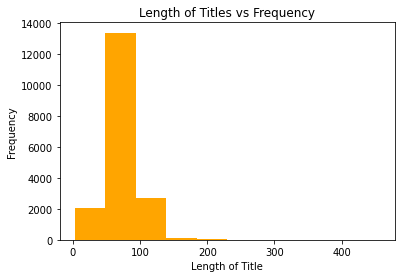

In [15]:
plt.title('Length of Titles vs Frequency')
plt.xlabel('Length of Title')
plt.ylabel('Frequency')
plt.hist(data['title'].apply(len), color='orange')
plt.show()

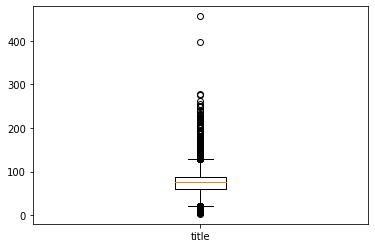

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xticklabels(['title'])
plt.boxplot(data['title'].apply(len))
plt.show()

[('admin', 193), ('Pakalert', 86), ('Eddy Lavine', 85), ('Starkman', 84), ('Alex Ansary', 82), ('Gillian', 82), ('Editor', 81), ('noreply@blogger.com (Alexander Light)', 80)]


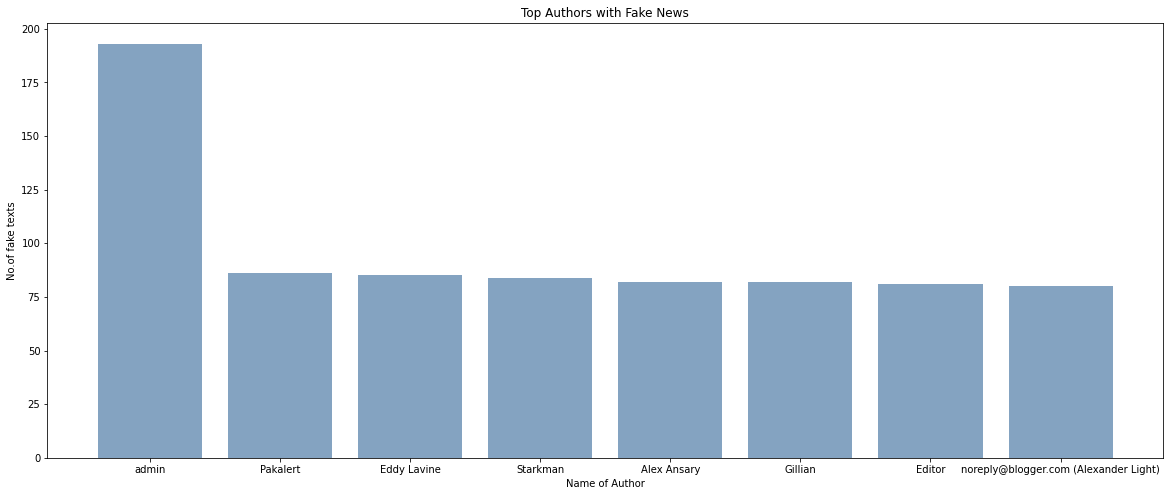

In [17]:
from collections import Counter

c = Counter(data['author'][data['label'] == 1]).most_common(8)
print(c)

x, y = zip(*c)

plt.figure(figsize=(20, 8))
plt.title('Top Authors with Fake News')
plt.xlabel('Name of Author')
plt.ylabel('No.of fake texts')
plt.bar(x, y, color=(0.2, 0.4, 0.6, 0.6))
plt.show()

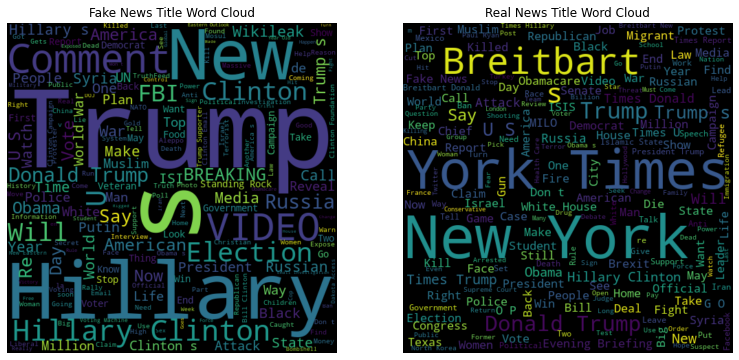

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


plt.figure(figsize=(13, 7))


# Fake News Word Cloud

text=(' '.join(data['title'][data['label'] == 1]))
wordcloud = WordCloud(width=480, height=480, margin=0).generate(text)

plt.subplot(1, 2, 1)
plt.title('Fake News Title Word Cloud')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


# Real News Word Cloud

text=(' '.join(data['title'][data['label'] == 0]))
wordcloud = WordCloud(width=480, height=480, margin=0).generate(text)

plt.subplot(1, 2, 2)
plt.title('Real News Title Word Cloud')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

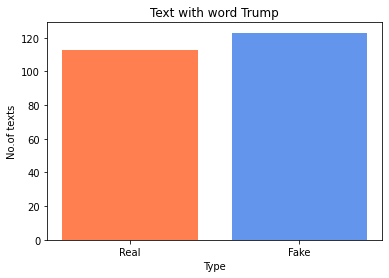

In [19]:
fake_trump_len = len(data[data['text'].str.contains('trump')][data['label'] == 1])
real_trump_len = len(data[data['text'].str.contains('trump')][data['label'] == 0])

plt.title('Text with word Trump')
plt.xlabel('Type')
plt.ylabel('No.of texts')
plt.bar(['Real', 'Fake'], [real_trump_len, fake_trump_len], color=['coral', 'cornflowerblue'])
plt.show()

**Combine necessary columns**

In [ ]:
data['content'] = data['author'] + '\n' + data['title'] + '\n' + data['text']
data.drop(columns = ['title', 'author', 'text'], inplace=True)

data['content'].dtype

dtype('O')

In [ ]:
data2 = pd.read_csv('indian_news.csv')
data2.rename(columns={'text': 'content'}, inplace=True)

label_dict = {'FAKE': 1, 'REAL': 0}

data2['label'] = data2.label.map(label_dict)



from string import ascii_letters, punctuation
allowed = set(ascii_letters)

def myfunc(x):
    x = str(x)
    words_list = x.split(' ')
    output = [word for word in words_list if any(letter in allowed for letter in word)]
    return (' '.join(output))

data2['content'] = data2['content'].apply(myfunc)

data = pd.concat([data, data2], ignore_index=True)

In [ ]:
data3 = pd.read_csv('liar.tsv', sep='\t')
data3.drop(data3.columns[[0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]], axis=1, inplace=True)
data3.columns = ['label', 'content']
label_dict = {'half-true': 0, 'mostly-true': 0, 'false': 1, 'true': 0, 'barely-true': 1, 'pants-fire': 1}
data3['label'] = data3.label.map(label_dict)

data = pd.concat([data, data3], ignore_index=True)

print(data)

       label                                            content
0          1  Darrell Lucus\nHouse Dem Aide: We Didn’t Even ...
1          0  Daniel J. Flynn\nFLYNN: Hillary Clinton, Big W...
2          1  Consortiumnews.com\nWhy the Truth Might Get Yo...
3          1  Jessica Purkiss\n15 Civilians Killed In Single...
4          1  Howard Portnoy\nIranian woman jailed for ficti...
...      ...                                                ...
32246      0  There are a larger number of shark attacks in ...
32247      0  Democrats have now become the party of the [At...
32248      0  Says an alternative to Social Security that op...
32249      1  On lifting the U.S. Cuban embargo and allowing...
32250      1  The Department of Veterans Affairs has a manua...

[32251 rows x 2 columns]


# Tokenization
It is the process of dividing a text into smaller units (each word will be an index in an array)

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
data['content'] = data.apply(lambda row: word_tokenize(row['content']), axis=1)
# data.iloc[0]['content']

# Lemmatization
It removes the endings of the word to the root word. It reduces the word children to a child.

In [ ]:
lemmatizer = WordNetLemmatizer()

def pos_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_tokens(tokens):
    nltk_tagged = pos_tag(tokens)  
    wordnet_tagged = map(lambda x: (x[0], pos_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_tokens = []
    
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_tokens.append(word)
        else:        
            lemmatized_tokens.append(lemmatizer.lemmatize(word, tag))
    return lemmatized_tokens


data['content'] = data['content'].apply(lemmatize_tokens)
# data.iloc[0]['content']

# Stop words Removal
Words like the and for will be eliminated from our dataset because they take too much room.

In [ ]:
stops = stopwords.words('english')
data['content'] = data['content'].apply(lambda x: [i for i in x if i not in stops and len(i) > 1])
data.iloc[0]['content']

['Darrell',
 'Lucus',
 'House',
 'Dem',
 'Aide',
 'We',
 'Didn',
 'Even',
 'See',
 'Comey',
 'Letter',
 'Until',
 'Jason',
 'Chaffetz',
 'Tweeted',
 'It',
 'House',
 'Dem',
 'Aide',
 'We',
 'Didn',
 'Even',
 'See',
 'Comey',
 'Letter',
 'Until',
 'Jason',
 'Chaffetz',
 'Tweeted',
 'It',
 'By',
 'Darrell',
 'Lucus',
 'October',
 '30',
 '2016',
 'Subscribe',
 'Jason',
 'Chaffetz',
 'stump',
 'American',
 'Fork',
 'Utah',
 'image',
 'courtesy',
 'Michael',
 'Jolley',
 'available',
 'Creative',
 'Commons-BY',
 'license',
 'With',
 'apology',
 'Keith',
 'Olbermann',
 'doubt',
 'Worst',
 'Person',
 'The',
 'World',
 'week–FBI',
 'Director',
 'James',
 'Comey',
 'But',
 'accord',
 'House',
 'Democratic',
 'aide',
 'look',
 'like',
 'also',
 'know',
 'second-worst',
 'person',
 'well',
 'It',
 'turn',
 'Comey',
 'send',
 'now-infamous',
 'letter',
 'announce',
 'FBI',
 'look',
 'email',
 'may',
 'relate',
 'Hillary',
 'Clinton',
 'email',
 'server',
 'ranking',
 'Democrats',
 'relevant',
 'com

In [ ]:
data['content'] = data['content'].apply(lambda x: ' '.join(x))

actual = actual_data.iloc[1]['text'][:535]
processed = data.iloc[1]['content'][65:464]

def print_side_by_side(a, b, size=50, space=4):
    print("Raw Text".ljust(size) + " " * (space // 2) + '|' + " " * (space // 2) + "Processed Text")
    print("="*(2 * size + space))
    while a or b:
        print(a[:size].ljust(size) + " " * (space // 2) + '|' + " " * (space // 2) + b[:size])
        a = a[size:]
        b = b[size:]

print_side_by_side(actual,processed)

Raw Text                                            |  Processed Text
Ever get the feeling your life circles the roundab  |  Ever get feeling life circle roundabout rather hea
out rather than heads in a straight line toward th  |  d straight line toward intend destination Hillary 
e intended destination? [Hillary Clinton remains t  |  Clinton remain big woman campus leafy liberal Well
he big woman on campus in leafy, liberal Wellesley  |  esley Massachusetts Everywhere else vote likely in
, Massachusetts. Everywhere else votes her most li  |  auguration dress remainder day way Miss Havisham f
kely to don her inauguration dress for the remaind  |  orever wear wed dress Speaking Great Expectations 
er of her days the way Miss Havisham forever wore   |  Hillary Rodham overflow 48 year ago first address 
that wedding dress.  Speaking of Great Expectation  |  Wellesley graduating class The president college 
s, Hillary Rodham overflowed with them 48 years ag  |  
o when she first addressed 

# Train Test Split

In [ ]:
train_X, test_X, train_Y, test_Y = train_test_split(data['content'], data['label'], test_size=0.3)

# Word Vectorization: TFIDF

- **Term Frequency:** This summarizes how often a given word appears within a document. <br/>
    TF = (#occurences of the word) / (#words in the doc)
- **Inverse Document Frequency:** This down scales words that appear a lot across documents. <br/>
    IDF = log((#documents) / (#documents containing the given word))
    
    TFIDF = TF * IDF

Without going into the math, TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents.

In [ ]:
tfidf_vect = TfidfVectorizer(max_features=5000)

tfidf_vect.fit(data['content'])

train_X_Tfidf = tfidf_vect.transform(train_X)
test_X_Tfidf = tfidf_vect.transform(test_X)


print(tfidf_vect.vocabulary_)

{'house': 2192, 'dem': 1270, 'aide': 239, 'we': 4851, 'even': 1634, 'see': 3996, 'comey': 950, 'letter': 2634, 'until': 4717, 'jason': 2445, 'it': 2426, 'by': 719, 'october': 3119, '30': 65, '2016': 48, 'subscribe': 4327, 'american': 297, 'utah': 4741, 'image': 2246, 'courtesy': 1130, 'michael': 2854, 'available': 462, 'creative': 1145, 'license': 2647, 'with': 4928, 'apology': 351, 'keith': 2517, 'doubt': 1429, 'person': 3332, 'the': 4492, 'world': 4948, 'week': 4865, 'fbi': 1761, 'director': 1360, 'james': 2436, 'but': 715, 'accord': 145, 'democratic': 1274, 'look': 2691, 'like': 2655, 'also': 281, 'know': 2547, 'second': 3987, 'well': 4875, 'turn': 4650, 'send': 4011, 'now': 3084, 'infamous': 2307, 'announce': 325, 'email': 1532, 'may': 2795, 'relate': 3738, 'hillary': 2141, 'clinton': 899, 'server': 4024, 'ranking': 3652, 'democrats': 1275, 'relevant': 3747, 'committee': 967, 'hear': 2108, 'they': 4505, 'find': 1805, 'via': 4777, 'tweet': 4653, 'one': 3151, 'republican': 3787, 'cha

# Naive Bayes

In [ ]:
Naive = MultinomialNB()

In [ ]:
best = cross_val_score(Naive, train_X_Tfidf, train_Y).mean()
best_clf = Naive
print("Cross Validation Score -> ", best)

from hyperopt import hp, tpe, fmin,STATUS_OK,Trials

def accuracy_model(params):
    clf = MultinomialNB(**params)
    return (cross_val_score(clf, train_X_Tfidf, train_Y).mean(), clf)

param_space = {
    'alpha': hp.choice('alpha', np.linspace(0.5, 1.5, 6)),
    'fit_prior': hp.choice('fit_prior', [True, False])
}

best_params = []
def f(params):
    global best, best_clf, best_params
    acc, clf = accuracy_model(params)
    if acc > best:
        best = acc
        best_clf = clf
        best_params = params
    return {'loss': -acc, 'status': STATUS_OK}

fmin(f, param_space , algo=tpe.suggest, max_evals=500)

Naive = best_clf
print('New best:', best, best_params)

Cross Validation Score ->  0.8074418604651162
100%|██████████| 500/500 [01:56<00:00,  4.28it/s, best loss: -0.8095681063122925]
New best: 0.8095681063122925 {'alpha': 0.9, 'fit_prior': False}


In [ ]:
Naive.fit(train_X_Tfidf, train_Y)

MultinomialNB(alpha=0.9, fit_prior=False)

In [ ]:
# predict the labels on validation dataset
predictions_NB_test = Naive.predict(test_X_Tfidf)
predictions_NB_train = Naive.predict(train_X_Tfidf)

# Use accuracy_score function to get the accuracy
accuracy_NB_test = accuracy_score(predictions_NB_test, test_Y) * 100
accuracy_NB_train = accuracy_score(predictions_NB_train, train_Y) * 100

print("Naive Bayes Accuracy Score -> ", accuracy_score(predictions_NB_test, test_Y)*100)

Naive Bayes Accuracy Score ->  81.19057461761058


# SVM

In [ ]:
SVM = SVC(kernel='linear', gamma='auto')

In [19]:
best = cross_val_score(SVM, train_X_Tfidf, train_Y).mean()
best_clf = SVM
print("Cross Validation Score -> ", best)

from hyperopt import hp, tpe, fmin,STATUS_OK,Trials

def accuracy_model(params):
    clf = SVC(kernel='linear', gamma='auto', **params)
    return (cross_val_score(clf, train_X_Tfidf, train_Y).mean(), clf)

param_space = {
    'C': hp.choice('C', np.linspace(0.1, 1000, 4))
}

best_params = []
def f(params):
    global best, best_clf, best_params
    acc, clf = accuracy_model(params)
    if acc > best:
        best = acc
        best_clf = clf
        best_params = params
    return {'loss': -acc, 'status': STATUS_OK}

fmin(f, param_space , algo=tpe.suggest, max_evals=2)

SVM = best_clf
print('New best:', best, best_params)

In [ ]:
# fit the training dataset on the classifier
SVM.fit(train_X_Tfidf, train_Y)

SVC(gamma='auto', kernel='linear')

In [ ]:
# predict the labels on validation dataset
predictions_SVM_test = SVM.predict(test_X_Tfidf)
predictions_SVM_train = SVM.predict(train_X_Tfidf)

# Use accuracy_score function to get the accuracy
accuracy_SVM_test = accuracy_score(predictions_SVM_test, test_Y) * 100
accuracy_SVM_train = accuracy_score(predictions_SVM_train, train_Y) * 100

print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM_test, test_Y)*100)

SVM Accuracy Score ->  83.66060355518809


# Decision Tree


In [ ]:
Decision_tree = DecisionTreeClassifier()

In [ ]:
best = cross_val_score(Decision_tree, train_X_Tfidf, train_Y).mean()
best_clf = Decision_tree
print("Cross Validation Score -> ", best)

from hyperopt import hp, tpe, fmin,STATUS_OK,Trials

def accuracy_model(params):
    clf = DecisionTreeClassifier(**params)
    return (cross_val_score(clf, train_X_Tfidf, train_Y).mean(), clf)

param_space = {
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': hp.choice('max_depth', [2, 3, 5, 10, 20]),
    'min_samples_leaf': hp.choice('min_samples_leaf', [5, 10, 20, 50, 100]),
}

best_params = []
def f(params):
    global best, best_clf, best_params
    acc, clf = accuracy_model(params)
    if acc > best:
        best = acc
        best_clf = clf
        best_params = params
    return {'loss': -acc, 'status': STATUS_OK}

fmin(f, param_space , algo=tpe.suggest, max_evals=50)

Decision_tree = best_clf
print('New best:', best, best_params)

Cross Validation Score ->  0.8079734219269102
100%|██████████| 50/50 [16:03<00:00, 19.27s/it, best loss: -0.8023477297895901]
New best: 0.8079734219269102 []


In [ ]:
# fit the training dataset on the classifier
Decision_tree.fit(train_X_Tfidf, train_Y)

DecisionTreeClassifier()

In [ ]:
# predict the labels on validation dataset
predictions_DT_test = Decision_tree.predict(test_X_Tfidf)
predictions_DT_train = Decision_tree.predict(train_X_Tfidf)

# Use accuracy_score function to get the accuracy
accuracy_DT_test = accuracy_score(predictions_DT_test, test_Y) * 100
accuracy_DT_train = accuracy_score(predictions_DT_train, train_Y) * 100

print("Decision Tree Accuracy Score -> ",accuracy_score(predictions_DT_test, test_Y)*100)

Decision Tree Accuracy Score ->  80.72550640760645


# Stacking Model

- Base Models are Naive Bayes, SVM and Decision Tree
- Meta Model is Logistic Regression
- Meta Model uses the outputs from the different classifiers to predict the given row's label for its training

In [ ]:
estimator_list = [
    ('nb', Naive),
    ('svc', SVM),
    ('dt', Decision_tree)]

# Build stack model
stack_model = StackingClassifier(
    estimators=estimator_list, final_estimator=LogisticRegression()
)

# fit the training dataset on the classifier
stack_model.fit(train_X_Tfidf, train_Y)

# predict the labels on validation dataset
predictions_stack_test = stack_model.predict(test_X_Tfidf)
predictions_stack_train = stack_model.predict(train_X_Tfidf)

# Use accuracy_score function to get the accuracy
accuracy_stack_test = accuracy_score(predictions_stack_test, test_Y) * 100
accuracy_stack_train = accuracy_score(predictions_stack_train, train_Y) * 100

print("Stacked Model Accuracy Score -> ",accuracy_score(predictions_stack_test, test_Y)*100)

Stacked Model Accuracy Score ->  84.18768085985946


In [ ]:
train_accuracies = ['Train', accuracy_NB_train, accuracy_SVM_train, accuracy_DT_train, accuracy_stack_train]
test_accuracies = ['Test', accuracy_NB_test, accuracy_SVM_test, accuracy_DT_test, accuracy_stack_test]
table = [['Data Type', 'Naive Bayes', 'SVM', 'Decision Tree', 'Stacked Model'], train_accuracies, test_accuracies]
print('Model Accuracy Scores')
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

Model Accuracy Scores
╒═════════════╤═══════════════╤═════════╤═════════════════╤═════════════════╕
│ Data Type   │   Naive Bayes │     SVM │   Decision Tree │   Stacked Model │
╞═════════════╪═══════════════╪═════════╪═════════════════╪═════════════════╡
│ Train       │       82.6357 │ 89.4662 │         99.9734 │         93.0676 │
├─────────────┼───────────────┼─────────┼─────────────────┼─────────────────┤
│ Test        │       81.1906 │ 83.6606 │         80.7255 │         84.1877 │
╘═════════════╧═══════════════╧═════════╧═════════════════╧═════════════════╛


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class InputTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vectorizer):
        self.vectorizer = vectorizer
        print("initalized InputTransformer")

    def fit(self, X, y=None):
        print('fit')
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        print('trasform')
        transformedX = self.vectorizer.transform(X_)
        return transformedX

In [ ]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('preprocessing', InputTransformer(tfidf_vect)),
                         ('average_model', stack_model)])
pipeline.fit(train_X, train_Y)

initalized InputTransformer
fit
trasform


Pipeline(steps=[('preprocessing',
                 InputTransformer(vectorizer=TfidfVectorizer(max_features=5000))),
                ('average_model',
                 StackingClassifier(estimators=[('nb',
                                                 MultinomialNB(alpha=0.9,
                                                               fit_prior=False)),
                                                ('svc',
                                                 SVC(gamma='auto',
                                                     kernel='linear')),
                                                ('dt',
                                                 DecisionTreeClassifier())],
                                    final_estimator=LogisticRegression()))])

In [ ]:
import pickle
pickle_out = open('classifier_final.pkl', "wb")
pickle.dump(pipeline, pickle_out)
pickle_out.close()

In [ ]:
from google.colab import files
files.download('classifier_final.pkl') 